# Neuromodulator Imaging Analysis

In this notebook, we will simulate the dynamics of neuromodulator concentration. For this we will start with:
- Simulation of a firing neuron, 
- Translate that to release of a neuromodulator. 
- Followed by a simulation of the signal $\Delta F/F$ produced by the changes in neuromodulator concentration.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

## 1. Simulation of firing neuron

Here, we define a function that simulates the activity of a single neuron. It takes the number of timesteps and firing rate of the neuron as arguments.

In [4]:
# define function that simulates a firing neuron

# it takes the number of timesteps(ms) + firing rate (Hz) as the argument
def simulate_neuron(n_timesteps, firing_rate):
    
    # generate a base array with random numbers between 0-1
    x = np.random.rand(n_timesteps)

    # Then populate the bins with signals - firing & not firing -- with a specific probability that you choose
    firing_neuron = x < 0.001*firing_rate
    firing_neuron = firing_neuron.astype(int)


    # then make a plot of it!
    plt.plot(firing_neuron)
    plt.xlabel('timesteps')
    plt.ylabel('Neuron activity')
    plt.title('Neuron Activity over {} timesteps'.format(n_timesteps))
    plt.show()


    # check exactly how many spikes were produced: to see if it works
    n_spikes = np.size(np.nonzero(firing_neuron))

    # print simulated neuron summary:
    print('Simulated neuron with {} spikes in {} timesteps ({} Hz).'.format(n_spikes, n_timesteps, firing_rate))
  

    return firing_neuron

# explicitly add dt = 1ms
# bonus: check at attosecond scale



Now let's visualize our firing neuron to see if we simulated it correctly

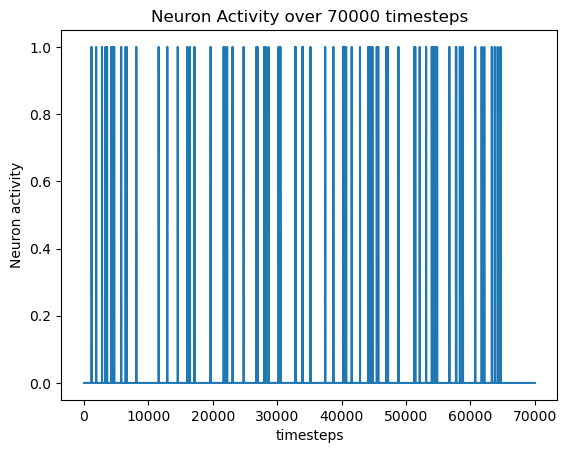

Simulated neuron with 81 spikes in 70000 timesteps (1 Hz).


In [5]:
# define the number of timesteps 70 seconds - 70000 milliseconds
# each timestep / bin is 1 ms wide

firing_neuron = simulate_neuron(n_timesteps=70000,firing_rate=1)

Ok, look's like the neuron is firing as we expect it to over 70,000 timesteps.

Bonus: run this function several times and histogram the n_spikes to see if it's actually a poisson w mean of 70 spikes.


### SIDE NOTE (extra -- not necessary to understand the rest of the simulation)
Below is an alternative approach to generating the spiking activity of a neuron, that makes use of the signal.unit_impulse feature of scipy.

remove later!

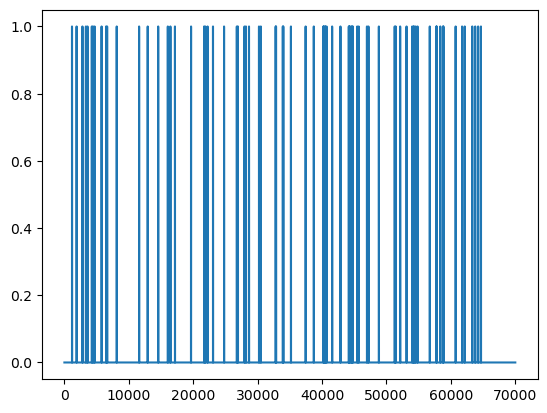

In [6]:
# timesteps where the neuron fired
firing_timesteps = np.nonzero(firing_neuron)

# generate visual representation of a train of spikes / I'll use this as the first approx. for the changes in [NM]
# ideally for the changes in [NM], we'd like to produce a chain of decaying exponents -- hopefully we produce them in a later cell

n_timesteps = 70000
spike_train = sp.signal.unit_impulse(n_timesteps,idx=firing_timesteps)

plt.plot(spike_train)

## 2. Neuromodulator concentration

Now let's simulate a simple case of neuromodulator release caused by our firing neuron. Here, we assume that the neuromodulator release occurs instantaneously, and that we are dealing with one compartment and there's no uptake. 

### Modelling [NM] using numerical integration

At each timestep:
- take previous value of [NM]; if t = 0,  use $[NM]_0$, the resting level concentration
- update [NM] value: 
    - add the change in [NM], $\ \Delta[NM]_{\Tau}$ due to an action potential, if t is a 'firing_timestep';
    - if it's not a firing timestep then subtract the 'infinitesimal' change in [NM], $\ \frac{d[NM]}{dt}$, at that timestep

In [7]:
# define the time constant tau -- play with this number: needs to be in OrderM ~ 2
# find a way to like scroll thru different value of this number
# tau = 500 is a good estimate to be able to see the trend

# define the steady state value of nm_conc -- ask Kenta for this number


# define function that takes in an array of neuron activity and gives corresponding [NM]
def simulate_nm_conc(neuron_activity,nm_conc0, k_b,k_r,gamma):


    # create array of [NM] with same size as neuron activity
    nm_conc = np.zeros(neuron_activity.size)

    # define delta_nm, the increase in [NM] due to a spike 
    # this will be a constant value  -- calculate the amplitude of the exponential function, A
    delta_nm = 1
    
    # first define tau the time constant
    tau = (1+k_r+k_b)/gamma


    # create a for-loop where we update the value of [NM] for current timestep
    for t in range(neuron_activity.size):
        
        # first timebin condition
        if t == 0 : 
            nm_conc[t] = nm_conc0 
        else: 
            nm_conc[t] = nm_conc[t-1]

        # update [NM] value

        # if there's a spike add Delta_nm else subtract d_nm/dt the inifinitesimal decay in [NM] in one timestep 
        if neuron_activity[t]==1: 
            nm_conc[t] = nm_conc[t] + delta_nm
        else: 
            d_nm_dt =  (nm_conc[t]-nm_conc0)/tau
            nm_conc[t] = nm_conc[t] - d_nm_dt 

    # plot the [NM] at all timesteps
    n_timesteps = neuron_activity.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # Calculate the concentrations of the bound forms of the NM
    # start with [NM B] the NM bound to the sensor
    nm_b_conc = k_b*nm_conc

    # then [NM R], the NM bound to the receptor
    nm_r_conc = k_r*nm_conc

    # then get the total nm concentration - both bound and unbound
    nm_tot = nm_conc + nm_b_conc + nm_r_conc

    # plot [NM], [NM B] and [NM R] simulataneously
    plt.plot(t,nm_conc, color = 'b', label='[NM]')
    plt.plot(t,nm_b_conc, color = 'g', label='[NM B]')
    plt.plot(t,nm_r_conc, color = 'r', label='[NM R]')


    # label the axes and make legend
    plt.xlabel('time (ms)')

    # # to zoom in on a plot
    # plt.xlim(5000,15000)

    plt.ylabel('(Change in) Concentration -- arbitrary units')
    plt.title('NM concentration across {} ms'.format(n_timesteps))
    plt.legend()
    plt.show() 
   

    # return the array of the [NM], [NM B], and [NM R]
    return nm_conc, nm_b_conc, nm_r_conc, nm_tot

# DOCUMENT THE CALCULATION FOR THE BOUND SENSOR



### Details

We obtain the values for [NM] at different timesteps by solving an ODE originally used to describe calcium dynamics in chromaffin cells (Neher & Augustine 1992), but later modified to describe calcium dynamics in dendrites of pyramidal neurons (Sakmann 1996):


$ \begin{equation} 
    \frac{d}{dt} [NM]\ (1 + \kappa_r + \kappa_B) = \Delta [NM]_{\Tau}\ \delta (t - t_{AP}) - \gamma ([NM] - [NM]_0), 
\end{equation}
$

where $\kappa_r$ and $\kappa_B$ are the dissociative constants associated with the receptor and sensor respectively, $\Delta [NM]_{\Tau}$ is the instantaneous increase in the [NM] caused by an action potential at time $t_{AP}$, $[NM]_0$ is the initial/rest [NM] and $\gamma$ is a constant associated with how quickly the [NM] returns to its rest value (confirm this last definition of $\gamma$).

There's two solutions to this equation:
$\begin{equation} \tag{2}
\begin{cases}
\ \ A\ e^{-t/\tau}\ ,\ t\ge t_{AP} \\ 
\ \ \ \ \ 0 \ \ \ \ ,\ \ \ t < t_{AP}
\end{cases} \end{equation}
$

which give us the change in $[NM]_i$ from resting level,$\ \ \Delta [NM]_i (t)  = [NM]_i - [NM]_{rest}$, and we also know that when an action potential occurs, we get an instantaneous increase in [NM] given by $[NM]_{\Tau}$. 

The amplitude A, and the time constant $\tau$, are defined as follows:

$\begin{equation} \tag{3}
    A = \frac{\Delta [NM]_\Tau}{1+ \kappa_B + \kappa_r}, \ \ \ \tau = \frac{1+\kappa_B + \kappa_r}{\gamma} 
\end{equation}
$



To obtain the changes in concentrations for the NM bound to the sensor, $\Delta$ [NM B], and the NM bound to the receptor $\Delta$ [NM R], the following relations (from Neher & Augustine) were used:

$\begin{equation} \tag{4} 
    \Delta [NM\ B] = \kappa_b \ \Delta [NM]_i
\end{equation}
$

$\begin{equation} \tag{5}
    \Delta [NM\ R] = \kappa_r \ \Delta [NM]_i
\end{equation}
$
Now let's test if our simulation for the concentrations are plausible.

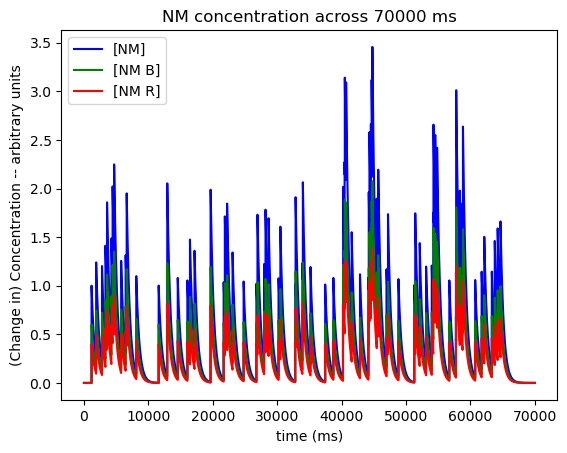

In [8]:
nm_conc, nm_b_conc, nm_r_conc, nm_tot = simulate_nm_conc(firing_neuron,nm_conc0=0,k_b=0.6, k_r=0.4,gamma=0.004)

Looks plausible from this scale. 
Next , let's try and zoom in and see the dynamics more closely.

In [9]:
# Takes in the 1st and last timebins that will be the bounds of the plot
# Produces a plot within those timesteps
def plot_nm_conc(nm,start,stop,colour='b', plotlabel = ''):

    # define the timesteps to plot the [NM]
    timesteps = stop - start + 1
    t = np.linspace(start,stop,timesteps)

    # get that section of the [NM] array
    nm_section = nm[start:stop+1]

    # plot the [NM] 
    plt.plot(t,nm_section, color=colour, label=plotlabel)
    plt.xlabel('time (ms)')
    plt.ylabel('NM concentration')
    plt.title('NM {} concentration from {} to {} ms'.format(plotlabel, start,stop))
    plt.show()

    #BONUS: plot the neuron activity corresponding to this time interval
    # right above the nm_conc plot




This function also allows us to separate the three different concentrations plot. You can view the whole range of any of the concentrations by changing the start and stop values to 0 and the last time value.

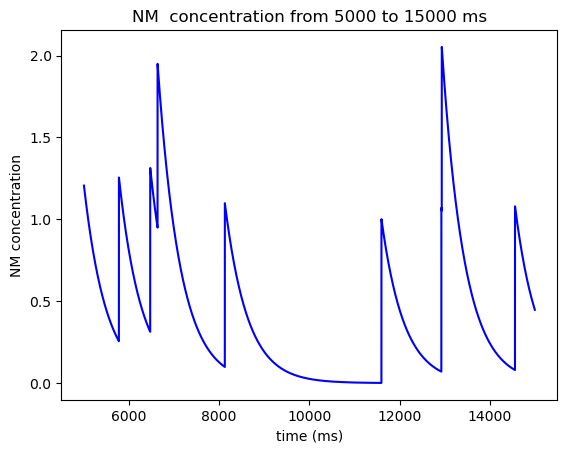

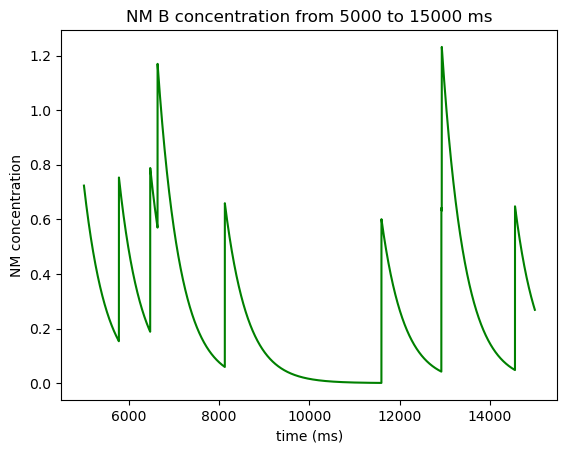

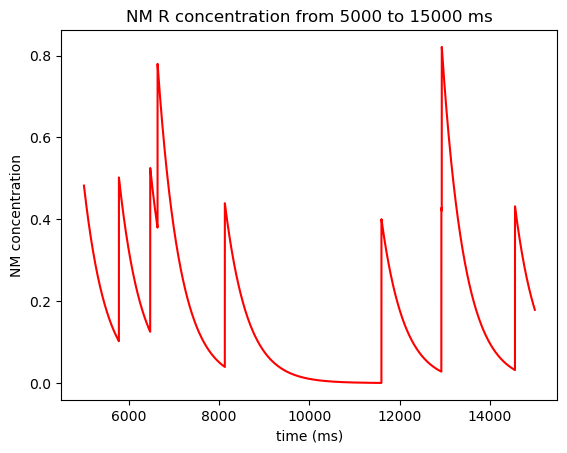

In [10]:
# Call the function on the different concentrations and change their start/stop values
plot_nm_conc(nm_conc, start = 5000,stop = 15000)
plot_nm_conc(nm_b_conc, start = 5000,stop = 15000, colour='g', plotlabel='B')
plot_nm_conc(nm_r_conc, start = 5000,stop = 15000, colour='r', plotlabel='R')

So far, the dynamics look plausible.

## 3. Flourescence Signal

Now, let's simulate the flourescence signal produced by the changes in the neuromodulator concentration, $\ \Delta$ [NM]. This is described by eq. 3 in the paper by Neher/Augustine -- 1992: 

$\begin{equation}
    \frac{\Delta F(t)}{F(0)} = \frac{(K'_D + [NM]_{i,t})/(K_D + [NM]_{i,t})}{(K'_D + [NM]_{i,0})/(K_D + [NM]_{i,0})} - 1
\end{equation}
$

where $K_D$ is the dissociation constant for the NM binding to the sensor, $\ [NM]_{i,0}\ $ is the initial (resting) [NM], $\ [NM]_{i,t}\ $ is the [NM] for the current timestep, and $K'_D$ is defined as:

$\begin{equation} \tag{2}
    K'_D = K_D\ (F_{min}/F_{max})
\end{equation}
$

where $\ F_{max}\ $ is the fluorescence when the sensor is completely bound to the NM and $\ F_{min}\ $ is the fluorescence when the sensor is completely unbound to the NM (unlike in what was described in the Neher/Augustine 1992 paper, where they used a 'negative sensor' such that the definition of $\ F_{max}\ $ and $\ F_{min}\ $ were switched).

In [11]:
# GET ACTUAL VALUES FROM KENTA

# function takes in 3 constants used in the equation to calculate F from [NM]:
    # 1.The dissociation constant for the NM binding to the sensor,K_D
    # 2.The fluorescence when sensor is completely bound to NM, F_max (positive sensor)
    # 3.The fluorescence when sensor is completely unbound to NM

def simulate_flourescence_signal(K_D, F_max, F_min, nm_conc):
    
    # define K_D prime as
    K_Dp = K_D*(F_min/F_max)

    # the initial/steady state concentration, [NM]i,0, of the neuromdultor
    # CONFIRM VALUE FROM KENTA
    nm_conc_0 = 0 

    # define the numerator and denominator
    numerator = (K_Dp + nm_conc)/(K_D + nm_conc)
    denominator = (K_Dp + nm_conc_0)/(K_D + nm_conc_0)

    # derive delta f/f0 by plugging in
    delta_ft_f0 = (numerator/denominator) - 1

    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,delta_ft_f0)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Flourescence intensity signal over time')

    return delta_ft_f0


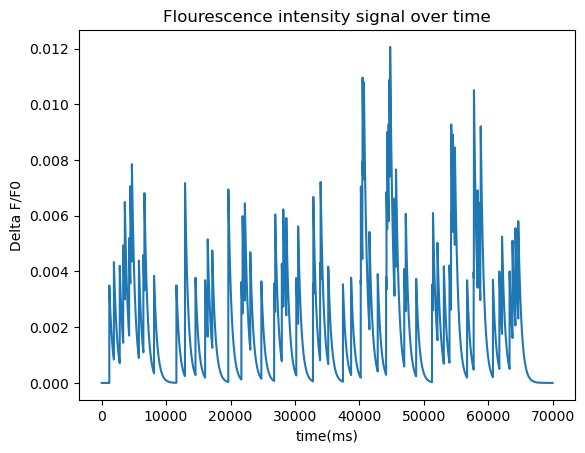

In [12]:
nm_conc_input = nm_conc
f_signal = simulate_flourescence_signal(K_D = 1000, F_max = 45, F_min = 10, nm_conc=nm_conc_input)

### Underlying relationship between the flourescence signal and [NM]

Now, let's see how changing the signal produced corresponds to [NM]. 

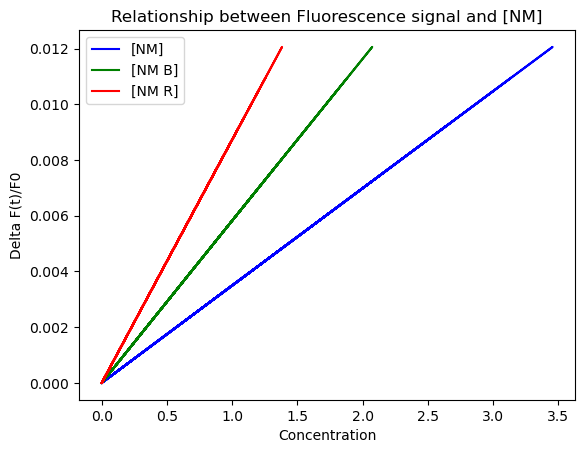

In [13]:
# plot the delta f vs the concentration

plt.plot(nm_conc,f_signal,color='b', label = '[NM]')
plt.plot(nm_b_conc,f_signal, color='g',label = '[NM B]')
plt.plot(nm_r_conc,f_signal, color='r',label = '[NM R]')
plt.xlabel('Concentration')
plt.ylabel('Delta F(t)/F0')
plt.title('Relationship between Fluorescence signal and [NM]')
plt.legend()


This linear relation confirms that the signal and changes in neuromodulator concentration producing this signal are directly related.


### 3.1 Alternate $\Delta F/ F$ calculation: using the normalized f(t) - f(0) method

This is actually the standard way to calculate the df/f signal but since this analysis began with the relation between the [NM] and fluorescence, this method will be referred to as the alternate method in this notebook.

Given value of fluoresence F, the formula to calculate the normalized signal $\Delta F/F$ is 
$\begin{equation}\tag{3}
    \frac{\Delta F}{F} (t) = \frac{F(t) - F_0 }{F_0}
\end{equation}
$


F is calculated from a formula that was derived from eq. 2 in Neher/Augustine:

$\begin{equation}\tag{4}
    F = \frac{K_D F_{min} + [NM] F_{max}}{K_D + [NM]}
\end{equation}
$

If we account for the autofluorescnce of the tissue, this value is increased by a constant factor $f_{tissue}$ and we can get the fluorescence as a function of time:

$\begin{equation}\tag{5}
F(t) = f_{tissue} + \frac{K_D F_{min} + [NM](t)\ F_{max}}{K_D + [NM](t)}
\end{equation}
$

In [14]:
# Define alternate function to simulate fluorescence
def alternate_simulate_f_signal(K_D, F_max, F_min, nm_conc):

    # autofluorescence
    f_tissue = 0.02

    # calculate F: derived from eq 2 in Neher/Augsutine
    f = f_tissue + (K_D*F_min + nm_conc*F_max)/(K_D + nm_conc)

    # calculate normalized signal: (assume f0 is the initial f value)
    delta_ft_f0 = (f-f[0])/f[0]

    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,delta_ft_f0)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Flourescence intensity signal over time')

    return delta_ft_f0

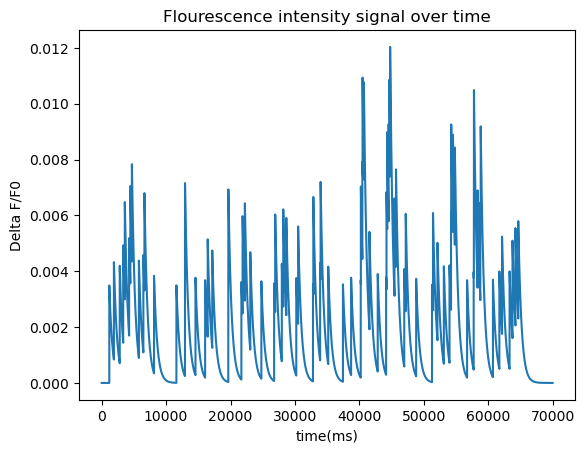

In [15]:
# Let's check if it's working now

alternate_f_signal = alternate_simulate_f_signal(K_D = 1000, F_max = 45, F_min = 10, nm_conc=nm_conc_input)

Confirming that this alternate method to calculate F yields the same F values as before:

In [16]:
# another check -- more precision -- they're equivalent up to 10 decimal places
np.array_equiv(np.round(f_signal,10),np.round(alternate_f_signal,10))

False

### 3.2 Computing  F0 using a moving baseline

This method will not yield simimlar values to the other two values by definition. But the hope is that the updates in the F0 value will account better for bleaching?** -- confirm what's the real reason behind this

In [17]:
def simulate_f_signal_bline(K_D, F_max, F_min, nm_conc, bline_len):

    # calculate F: derived from eq 2 in Neher/Augsutine
    f = (K_D*F_min + nm_conc*F_max)/(K_D + nm_conc)
    

    # define the signal array
    delta_ft_f0 = np.zeros(f.size)


    # calculate f0 values and populate the signal array
    for i in range(f.size):

        # calculate f0 by averaging the previous x number of f values
        # if x is bigger than the current index then use all the prev f values
        # where x is the length of the moving baseline

        if i < bline_len:
            f0 = np.average(f[:i])
        else: 
            f0 = np.average(f[i-bline_len:i])

        # calculate normalized signal using the calculated f0
        delta_ft_f0[i] = (f[i]-f0)/(f0)


    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,delta_ft_f0)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Flourescence intensity signal over time')

    return delta_ft_f0

# BONUS: use weighted average to calculate the baseline later on

/Users/brian.gitahi/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/brian.gitahi/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


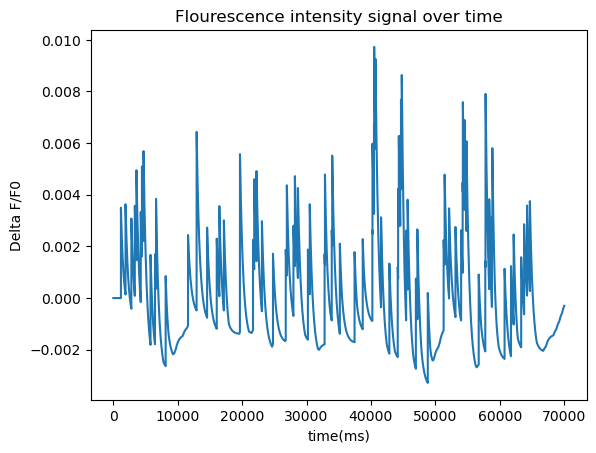

In [18]:
bline_f_signal = simulate_f_signal_bline(K_D = 1000, F_max = 45, F_min = 10, nm_conc=nm_conc_input,bline_len=5000)

Not sure what the run time warning is about but the resulting plot looks plausible

Let's try the same thing but calculate the baseline in a more 'standard' way. We're going to calculate the F0 value to use by taking the median value of the bottom 70% of the previous x values of f.

In [117]:
def simulate_f_signal_bline2(tau_dnm, tau_tissue, nm_conc=nm_conc_input, K_D = 1000, F_max = 45, F_min = 10, bline_len=5000):

    # autofluorescence
    f_tissue = 0.02

    # create timesteps 
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # define bleach factors for the autofluorescence and fluorescence from dye + nm
    bleach_dnm = np.exp(-t/tau_dnm)
    bleach_tissue = np.exp(-t/tau_tissue)
    
    # calculate F: derived from eq 2 in Neher/Augsutine
    f = bleach_tissue*f_tissue + bleach_dnm*(K_D*F_min + nm_conc*F_max)/(K_D + nm_conc)

    # fitting polynomial comes later

    # calculate f0 by getting the median value of the bottom 70% of previous f values
    percentile_mark = np.percentile(f,70)
    f0 = np.median(f[f<percentile_mark])
    
    # df calc -- median value method
    df = f-f0
    df_f_med = df/f0

    # define the and delta f and the df/f signal arrays
    df_f_ave = np.zeros(f.size)
    f0_averages = np.zeros(f.size)
    


    # calculate f0 values and populate the signal array
    for i in range(f.size):

        # calculate f0 using the average method
        if i==0:
            f0_ave=f[0]
        
        elif i < bline_len:
            f0_ave = np.average(f[:i]) 
        else: 
            f0_ave = np.average(f[i-bline_len:i]) 

        # calculate normalized signal using the calculated f0
    
        
        # average value
        df_f_ave[i] = (f[i] - f0_ave)/f0_ave
        f0_averages[i]=f0_ave

    return f, df, df_f_ave, df_f_med 

    

Plot the progression: f until df/f

In [114]:
# plot the progression from f -- df/f
def plot_f_signal(f,df,df_f_ave,df_f_med):

    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(t,f, label='f')
    plt.xlabel('time (ms)')
    plt.ylabel('f')
    plt.title('f  vs time')
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(t,df, label='df')
    plt.xlabel('time (ms)')
    plt.ylabel('df')
    plt.title('df vs time')
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(t,df_f_ave, label='df/f')
    plt.xlabel('time (ms)')
    plt.ylabel('df/f')
    plt.title('df/f vs time (f0:average)')
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(t,df_f_med, label = 'df/f')
    plt.xlabel('time(ms)')
    plt.ylabel(' df/f')
    plt.title('df/f vs time (f0:median)')
    plt.tight_layout()
    plt.legend()

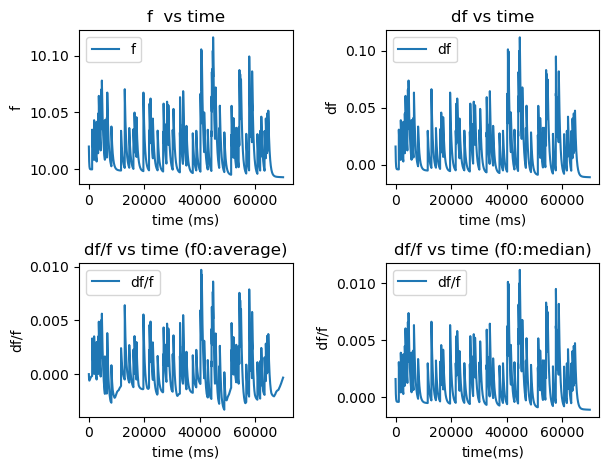

In [125]:
# simulate the fluorescence signal and plot 
f , df , df_f_ave, df_f_med = simulate_f_signal_bline2(tau_dnm=10e7, tau_tissue=10e1)
plot_f_signal(f,df,df_f_ave, df_f_med)

In [123]:
# This function checks the bleaching effect for all combinations of the two bleach factors
# and outputs a heatmap to show effects of bleaching different sources of hte f value

def bleach_nm(tau_values):

    # create an array to store the snr values
    snr = np.zeros((tau_values.size, tau_values.size))

    # find way to do it that's more effecient -- this is O(n^2)
    for i in range(len(tau_values)):
        for j in range(len(tau_values)):
            signal = simulate_f_signal_bline2(tau_dnm=tau_values[i], tau_tissue=tau_values[j])
            snr[i,j] = np.mean(signal)/np.std(signal)
    

    # Generate the heatmap
    plt.imshow(snr)
    plt.xlabel('bleach factor in tissue fluorescence')
    plt.ylabel('bleach factor in nm flourescence')
    plt.title('Signal to noise ratio for different bleach factor combinations')
    plt.show()

    return snr


# get values of SNR for increasing bleach factor ([NM] version) at different values of bleach factor (tissue version)


/Users/brian.gitahi/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


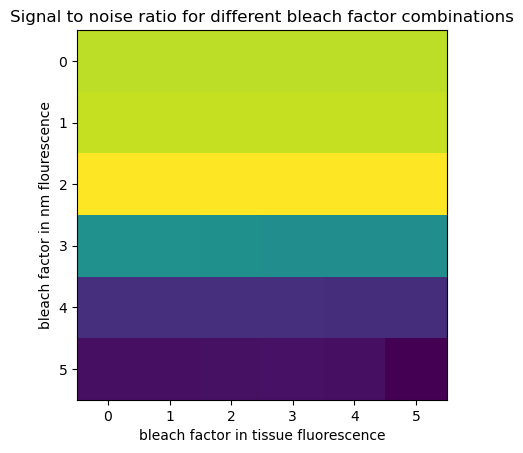

array([[0.5782468 , 0.57825064, 0.57833589, 0.57842891, 0.57826899,
        0.57824959],
       [0.5849869 , 0.58499872, 0.58510661, 0.58521028, 0.58502173,
        0.5850031 ],
       [0.64110212, 0.64110992, 0.64118773, 0.64131602, 0.64120789,
        0.64120482],
       [0.3255303 , 0.32510132, 0.32165726, 0.31488084, 0.31471493,
        0.31476297],
       [0.08714467, 0.08712359, 0.08700881, 0.08612622, 0.08486242,
        0.08484845],
       [0.02598925, 0.02627133, 0.02871999, 0.03143645, 0.02716971,
        0.        ]])

In [124]:
# input tau values
different_taus = np.array([10e6,10e5,10e4,10e3,10e2,10e1])

# run the simulation with different bleach factors on the different sources of fluorescence
bleach_nm(different_taus)